## Import Libraries

In [1]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, Reshape, concatenate, RepeatVector, Conv2DTranspose
import numpy as np
from tensorflow.keras.initializers import TruncatedNormal
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input as inception_preprocess
!pip install tensorflow_io
import tensorflow_io as tfio
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 21.4 MB/s eta 0:00:00


## Setup GPU

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f'Available GPUs: {len(gpus)}')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Available GPUs: 0


## Load the Dataset

In [2]:
(x_train, _), (x_test, _) = cifar10.load_data()
print(f'Number of training images: {len(x_train)}')
print(f'Number of testing images: {len(x_test)}')

170498071/170498071 [==============================] - 19s 0us/step
Number of training images: 50000
Number of testing images: 10000


## Extract a random subset from the training and testing sets

In [3]:
n_train = x_train.shape[0]
idx = np.random.permutation(n_train)[:3000]
x_train = x_train[idx]
n_test = x_test.shape[0]
idx = np.random.permutation(n_test)[:600]
x_test = x_test[idx]
print(f'New number of training images: {len(x_train)}')
print(f'New number of testing images: {len(x_test)}')
NUM_IMAGES = len(x_train)

New number of training images: 3000
New number of testing images: 600


## Visualize the Dataset

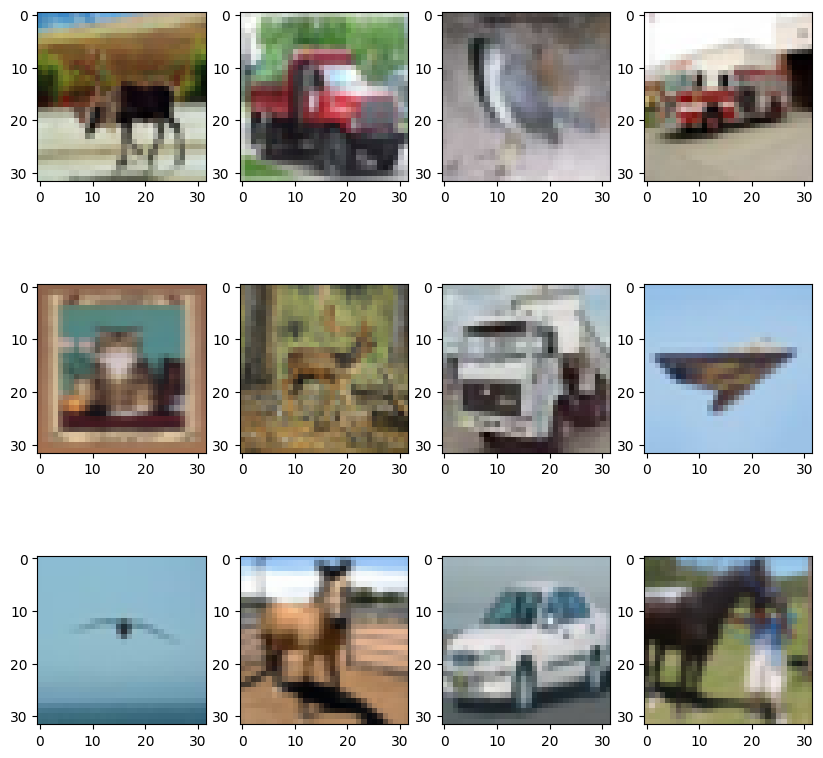

In [ ]:
plt.figure(figsize=(10,10))
sample_indices = np.random.choice(NUM_IMAGES, 12)
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(x_train[sample_indices[i]])

## Instantiate an Inception-ResNet v2 Model to Extract High-Level Features

In [4]:
inception_resnet_model = InceptionResNetV2(include_top=True, weights='imagenet',
                                          classifier_activation=None)
# Since we only need the output of the last layer before the softmax function, activation is set to None

225209952/225209952 [==============================] - 12s 0us/step


## Prepare Dataset

#### Create an Image Generator

In [5]:
image_generator = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True)

#### Create the Dataset Generator

In [6]:
def dataset_generator(data, batch_size=64):
    for image_batch in image_generator.flow(data, batch_size=batch_size):
        image_batch = tf.cast(image_batch, dtype=tf.float32)
        lab_image = image_batch / 255.0

        # Convert to LAB encoding
        lab_image = tfio.experimental.color.rgb_to_lab(lab_image, illuminant='D65', observer='2') / 128
        # Resize to 224 × 224
        lab_image = tf.image.resize(lab_image, (224, 224))

        # Remove the L dimension for the decoder branch
        dec_image = lab_image[:,:,:,1:]

        # Store the L dimension for the grayscale image
        enc_image = lab_image[:,:,:,:1]
        # Copy the encoded images thrice along the depth axis to get images
        # of size (224,224,3) for the Resnet50 model
        enc_image = tf.squeeze(tf.stack([enc_image]*3,axis=3))
        # proprocess the images according to Resnet50's specifications
        enc_image = resnet_preprocess(tf.cast(255.0*enc_image,tf.uint64))

        # Resize to 299 × 299  for the Inception-ResNet v2 Model
        inc_image = tf.image.resize(tf.image.rgb_to_grayscale(image_batch), (299, 299))

        # Make the inc_image three-dimensional
        inc_image = tf.reshape(inc_image, (-1, 299, 299))
        inc_image = tf.stack((inc_image,inc_image,inc_image),axis=3)

        # Center and scale the pixel values in order to obtain values within the
        # interval of [−1, 1]
        inc_image = inception_preprocess(inc_image)

        # Pass the inc_image through the Inception ResNet v2 Model
        features = inception_resnet_model(inc_image)

        yield {'enc_image':enc_image, 'features':features}, dec_image

## Create Deep CNN

### Encoder Architecture

In [7]:
enc_input = Input(shape=(224,224,3), name='EncoderInput')

resnet50_model = ResNet50(include_top=False, weights='imagenet')
truncated_model = tf.keras.Model(inputs = resnet50_model.layers[0].input, outputs = resnet50_model.layers[-48].output, name='TruncatedResnet50')
truncated_model.trainable = False
resnet50_output = truncated_model(enc_input, training=False)

enc_output = Conv2DTranspose(filters=256,kernel_size=(2,2), strides=(2,2),
                            kernel_initializer=TruncatedNormal(stddev=0.02),activation='relu')(resnet50_output)

94765736/94765736 [==============================] - 5s 0us/step


### Fusion Architecture

In [8]:
fusion_input = Input(shape=(1000), name='FusionInput')

repeat_layer = RepeatVector(28*28, name='RepeatLayer')(fusion_input)
reshape_layer = Reshape([28,28,1000], name='ReshapeLayer')(repeat_layer)
conc_layer = concatenate([enc_output, reshape_layer], axis=3)

fusion_output = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02),  activation='relu',
              name='Conv2D_LayerF1')(conc_layer)

### Decoder Architecture

In [9]:
conv_layer = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02), activation='relu',
              name='Conv2D_LayerD1')(fusion_output)
upsamp_layer = UpSampling2D(size=(2,2), name='UpSampling_D1')(conv_layer)

conv_layer = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02), activation='relu',
              name='Conv2D_LayerD2')(upsamp_layer)
upsamp_layer = UpSampling2D(size=(2,2), name='UpSampling_D2')(conv_layer)

conv_layer = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02), activation='relu',
              name='Conv2D_LayerD3')(upsamp_layer)
conv_layer = Conv2D(filters=2, kernel_size=(3,3), strides=(1,1), padding='same',
              kernel_initializer=TruncatedNormal(stddev=0.02), activation='tanh',
              name='Conv2D_LayerD4')(conv_layer)

dec_output = UpSampling2D(size=(2,2), name='UpSampling_D3')(conv_layer)

### Connected Model

In [10]:
coloriser = tf.keras.Model(inputs={'enc_image':enc_input, 'features':fusion_input}, outputs=dec_output, name='ColoriserModel')
coloriser.summary()

Model: "ColoriserModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 EncoderInput (InputLayer)   [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 FusionInput (InputLayer)    [(None, 1000)]               0         []                            
                                                                                                  
 TruncatedResnet50 (Functio  (None, None, None, 256)      7200128   ['EncoderInput[0][0]']        
 nal)                                                                                             
                                                                                                  
 RepeatLayer (RepeatVector)  (None, 784, 1000)            0         ['FusionInput[0][

## Compile CNN Model

In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_squared_error as mse

In [12]:
def psnr(y_true, y_pred):
  return tf.image.psnr(y_true, y_pred, max_val=1.0)

coloriser.compile(optimizer=Adam(learning_rate=0.001), loss=mse, metrics = ['accuracy','mae','mse',psnr])

## Train the Model

In [ ]:
checkpoint_filepath = '/tmp/ckpt/checkpoint1.model.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True)
training_history = coloriser.fit(dataset_generator(x_train), epochs=300, steps_per_epoch=30,callbacks=[model_checkpoint_callback])

Epoch 1/300
30/30 [==============================] - 41s 1s/step - loss: 0.0101 - accuracy: 0.6175 - mae: 0.0692 - mse: 0.0101 - psnr: 22.1399
Epoch 2/300
30/30 [==============================] - 40s 1s/step - loss: 0.0097 - accuracy: 0.6660 - mae: 0.0673 - mse: 0.0097 - psnr: 22.2824
Epoch 3/300
30/30 [==============================] - 42s 1s/step - loss: 0.0098 - accuracy: 0.6493 - mae: 0.0674 - mse: 0.0098 - psnr: 22.1979
Epoch 4/300
30/30 [==============================] - 37s 1s/step - loss: 0.0096 - accuracy: 0.6494 - mae: 0.0666 - mse: 0.0096 - psnr: 22.4173
Epoch 5/300
30/30 [==============================] - 35s 1s/step - loss: 0.0089 - accuracy: 0.6613 - mae: 0.0653 - mse: 0.0089 - psnr: 22.3709
Epoch 6/300
30/30 [==============================] - 37s 1s/step - loss: 0.0094 - accuracy: 0.6579 - mae: 0.0663 - mse: 0.0094 - psnr: 22.3473
Epoch 7/300
30/30 [==============================] - 35s 1s/step - loss: 0.0091 - accuracy: 0.6658 - mae: 0.0653 - mse: 0.0091 - psnr: 22.4845

In [ ]:
from google.colab import files
files.download(checkpoint_filepath)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualize the Training History

### Training Loss

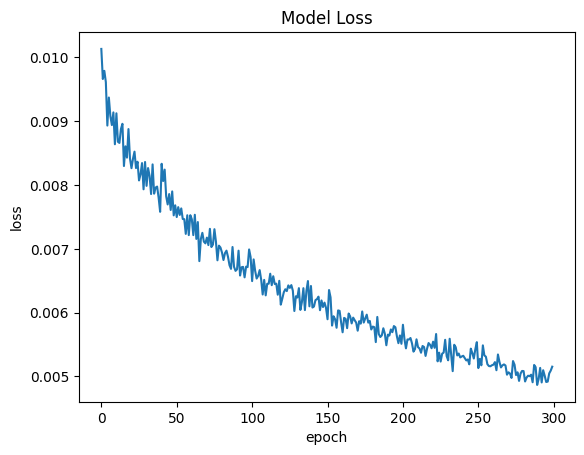

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(training_history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('colorizer_loss_P1.png')
files.download('colorizer_loss_P1.png')

### Metrics

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

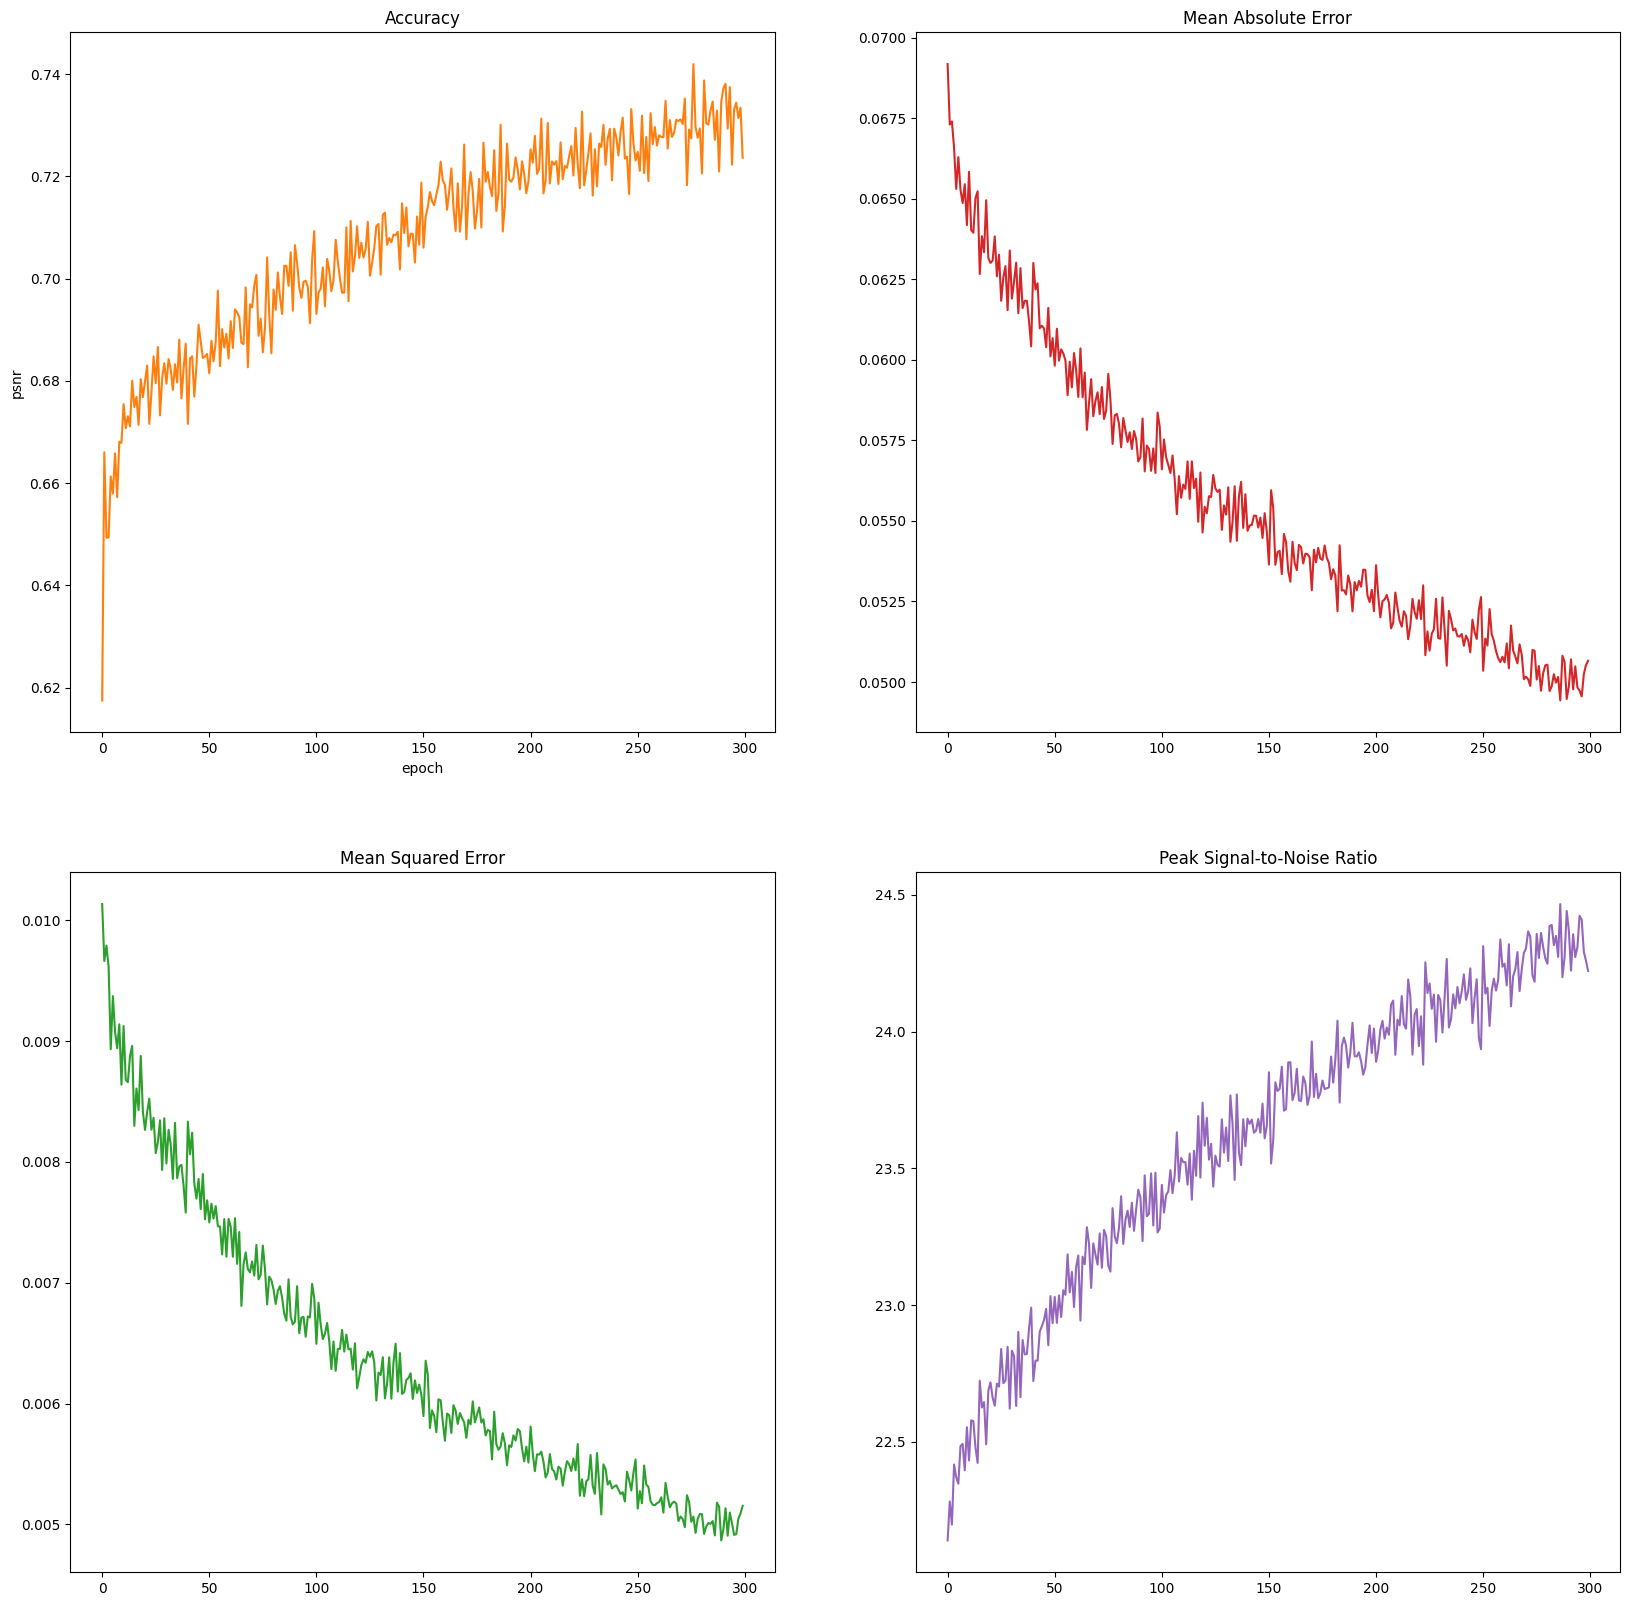

In [ ]:
figs, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,20))

axes[0,0].plot(training_history.history['accuracy'],'tab:orange')
axes[0,0].set_title('Accuracy')
axes[0,0].set(xlabel='epoch', ylabel='acc')

axes[0,1].plot(training_history.history['mae'],'tab:red')
axes[0,1].set_title('Mean Absolute Error')
axes[0,0].set(xlabel='epoch', ylabel='mae')

axes[1,0].plot(training_history.history['mse'],'tab:green')
axes[1,0].set_title('Mean Squared Error')
axes[0,0].set(xlabel='epoch', ylabel='mse')

axes[1,1].plot(training_history.history['psnr'],'tab:purple')
axes[1,1].set_title('Peak Signal-to-Noise Ratio')
axes[0,0].set(xlabel='epoch', ylabel='psnr')

plt.savefig('colorizer_metrics_P1.png')
files.download('colorizer_metrics_P1.png')

## Fine Tuning

In [ ]:
coloriser.load_weights('/tmp/ckpt/checkpoint1.model.keras')

In [16]:
from google.colab import drive
drive.mount('/content/drive')
coloriser.load_weights('/content/drive/My Drive/checkpoint2.model.keras')

Mounted at /content/drive


In [14]:
truncated_model.trainable = True
for i in range(60):
  truncated_model.layers[i].trainable = False

In [15]:
coloriser.compile(optimizer=Adam(learning_rate=0.0001), loss=mse, metrics = ['accuracy','mae','mse',psnr])

In [ ]:
checkpoint_filepath_2 = '/tmp/ckpt/checkpoint2.model.keras'
model_checkpoint_callback_2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_2,
    monitor='loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True)
training_history_2 = coloriser.fit(dataset_generator(x_train), epochs=400, steps_per_epoch=30,initial_epoch=300,callbacks=[model_checkpoint_callback_2])

Epoch 301/400
30/30 [==============================] - 50s 1s/step - loss: 0.0051 - accuracy: 0.7373 - mae: 0.0504 - mse: 0.0051 - psnr: 24.2067
Epoch 302/400
30/30 [==============================] - 38s 1s/step - loss: 0.0047 - accuracy: 0.7252 - mae: 0.0483 - mse: 0.0047 - psnr: 24.6342
Epoch 303/400
30/30 [==============================] - 37s 1s/step - loss: 0.0047 - accuracy: 0.7439 - mae: 0.0484 - mse: 0.0047 - psnr: 24.5553
Epoch 304/400
30/30 [==============================] - 41s 1s/step - loss: 0.0046 - accuracy: 0.7317 - mae: 0.0479 - mse: 0.0046 - psnr: 24.6686
Epoch 305/400
30/30 [==============================] - 42s 1s/step - loss: 0.0046 - accuracy: 0.7458 - mae: 0.0479 - mse: 0.0046 - psnr: 24.6210
Epoch 306/400
30/30 [==============================] - 42s 1s/step - loss: 0.0047 - accuracy: 0.7324 - mae: 0.0484 - mse: 0.0047 - psnr: 24.5661
Epoch 307/400
30/30 [==============================] - 38s 1s/step - loss: 0.0046 - accuracy: 0.7384 - mae: 0.0477 - mse: 0.0046 -

In [ ]:
from google.colab import files
files.download(checkpoint_filepath_2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualize Fine-Tuning History

### Training Loss

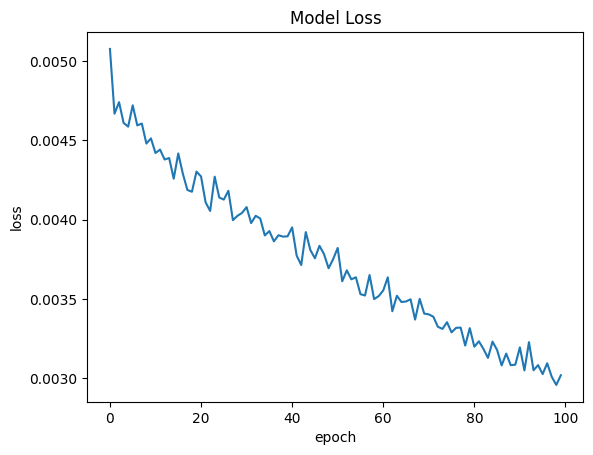

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(training_history_2.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('colorizer_loss_P2.png')
files.download('colorizer_loss_P2.png')

### Metrics

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

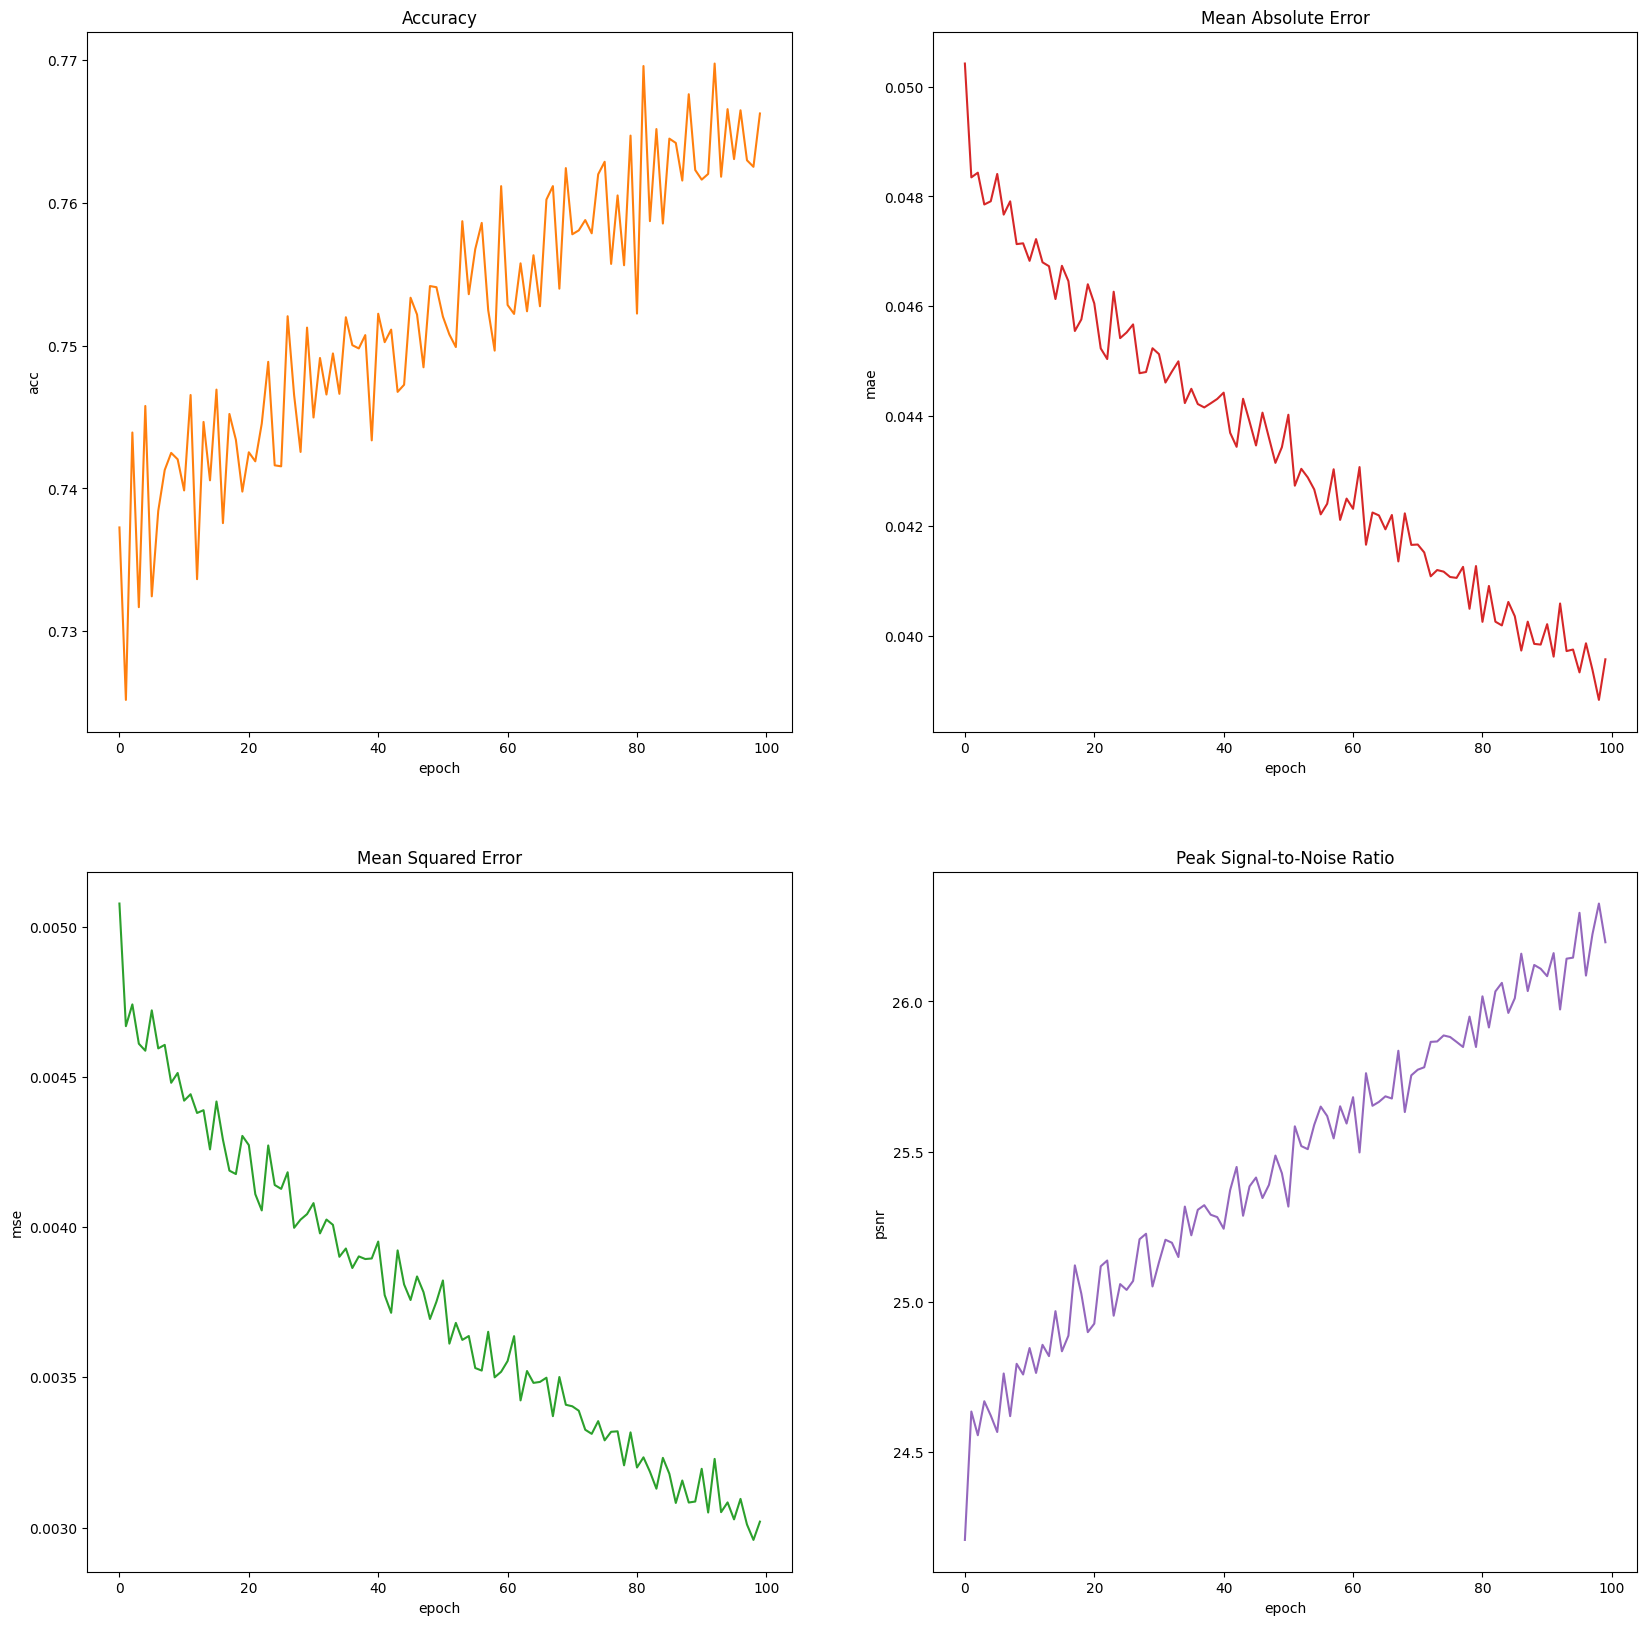

In [ ]:
figs, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,20))

axes[0,0].plot(training_history_2.history['accuracy'],'tab:orange')
axes[0,0].set_title('Accuracy')
axes[0,0].set(xlabel='epoch', ylabel='acc')

axes[0,1].plot(training_history_2.history['mae'],'tab:red')
axes[0,1].set_title('Mean Absolute Error')
axes[0,1].set(xlabel='epoch', ylabel='mae')

axes[1,0].plot(training_history_2.history['mse'],'tab:green')
axes[1,0].set_title('Mean Squared Error')
axes[1,0].set(xlabel='epoch', ylabel='mse')

axes[1,1].plot(training_history_2.history['psnr'],'tab:purple')
axes[1,1].set_title('Peak Signal-to-Noise Ratio')
axes[1,1].set(xlabel='epoch', ylabel='psnr')

plt.savefig('colorizer_metrics_P2.png')
files.download('colorizer_metrics_P2.png')

## Test Model

In [45]:
x_test_ = tf.image.rgb_to_grayscale(x_test) # convert to black and white for testing
x_test_ = tf.squeeze(tf.stack([x_test_]*3,axis=3)) # make the image 3D for processing them

In [46]:
res = coloriser.evaluate(dataset_generator(x_test_),steps=200)

200/200 [==============================] - 201s 1s/step - loss: 0.0061 - accuracy: 0.7099 - mae: 0.0524 - mse: 0.0061 - psnr: 24.6224


In [52]:
np.array(res)[:,np.newaxis]

array([[6.08466472e-03],
       [7.09910512e-01],
       [5.23929484e-02],
       [6.08466379e-03],
       [2.46223564e+01]])

In [54]:
import pandas as pd
test_res = pd.DataFrame(res, index=['Loss', 'Accuracy', 'MAE', 'MSE', 'PSNR'],columns=['Score']).T
test_res

,Loss,Accuracy,MAE,MSE,PSNR
Score,0.006085,0.709911,0.052393,0.006085,24.622356


## Visualize the Output

In [55]:
def feed(test_data):
    image_batch = tf.cast(test_data, dtype=tf.float32)
    lab_image = image_batch / 255.0
    lab_image = tfio.experimental.color.rgb_to_lab(lab_image, illuminant='D65', observer='2') / 128
    lab_image = tf.image.resize(lab_image, (224, 224))
    enc_image = lab_image[:,:,:,:1]
    enc_image = tf.squeeze(tf.stack([enc_image]*3,axis=3))
    enc_image = resnet_preprocess(tf.cast(255.0*enc_image,tf.uint64))
    inc_image = tf.image.resize(tf.image.rgb_to_grayscale(image_batch), (299, 299))
    inc_image = tf.reshape(inc_image, (-1, 299, 299))
    inc_image = tf.stack((inc_image,inc_image,inc_image),axis=3)
    inc_image = inception_preprocess(inc_image)
    features = inception_resnet_model(inc_image)
    return coloriser.predict({'enc_image':enc_image, 'features':features})

In [63]:
num_img_for_vis = 25

idx = np.random.permutation(len(x_test_))[:num_img_for_vis]
actual_images = x_test[idx]
bw_images = x_test_.numpy()[idx]
predictions = feed(actual_images)

1/1 [==============================] - 0s 73ms/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

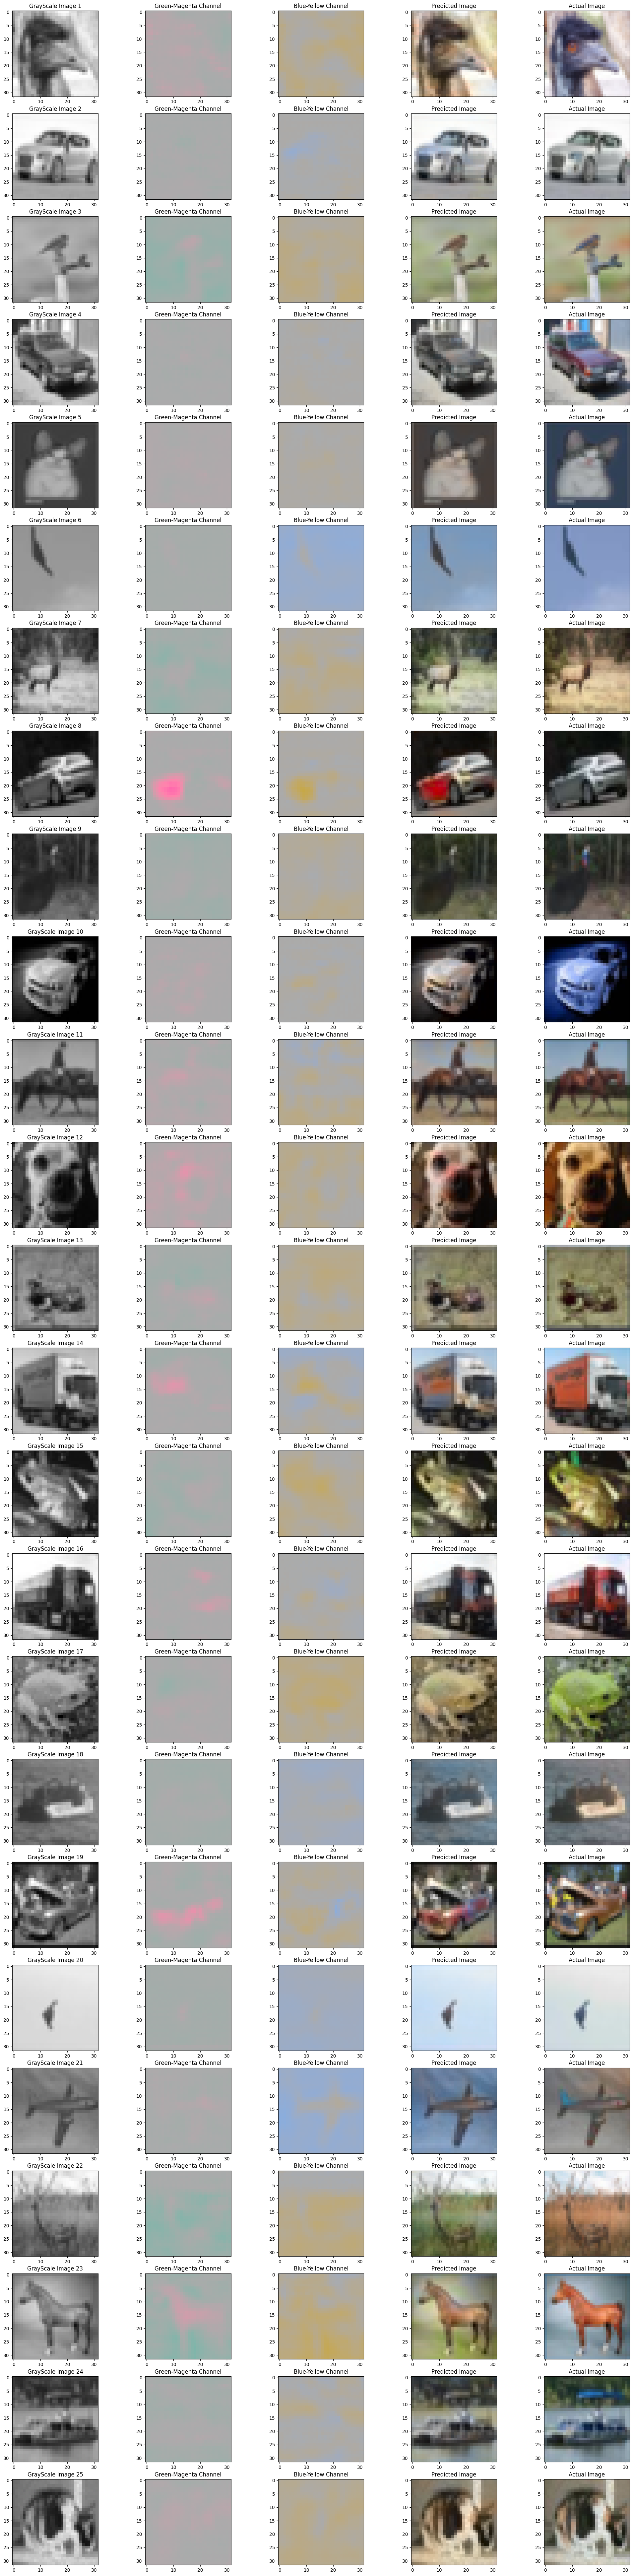

In [65]:
_, ax = plt.subplots(num_img_for_vis, 5, figsize=(25,100))
for i in range(num_img_for_vis):
    img = tf.image.resize(predictions[i], (32,32))
    lab_image_actual = tfio.experimental.color.rgb_to_lab(actual_images[i]/255.0, illuminant='D65', observer='2') / 128.0
    l_comp = lab_image_actual[:,:,0]
    full_img = np.zeros((img.shape[0],img.shape[1],3))
    full_img[:,:,0]=l_comp
    full_img[:,:,1:]=img
    full_img = full_img * 128
    lab_a = np.zeros(full_img.shape)
    lab_b = np.zeros(full_img.shape)
    lab_a[:,:,0] = 70 # Arbitrary moderately-high luminance value for visualization of channel 'a'
    lab_b[:,:,0] = 70 # Arbitrary moderately-high luminance value for visualization of channel 'b'
    lab_a[:,:,1] = full_img[:,:,1]
    lab_b[:,:,2] = full_img[:,:,2]
    full_img = tfio.experimental.color.lab_to_rgb(full_img, illuminant='D65', observer='2')
    lab_a = tfio.experimental.color.lab_to_rgb(lab_a, illuminant='D65', observer='2')
    lab_b = tfio.experimental.color.lab_to_rgb(lab_b, illuminant='D65', observer='2')
    ax[i][0].imshow(bw_images[i],cmap='gray')
    ax[i][0].title.set_text('GrayScale Image '+str(i+1))
    ax[i][1].imshow(lab_a)
    ax[i][1].title.set_text('Green-Magenta Channel')
    ax[i][2].imshow(lab_b)
    ax[i][2].title.set_text('Blue-Yellow Channel')
    ax[i][3].imshow(full_img)
    ax[i][3].title.set_text('Predicted Image')
    ax[i][4].imshow(actual_images[i])
    ax[i][4].title.set_text('Actual Image')
    name = '/content/drive/My Drive/KoalaRes/'
    tf.keras.utils.save_img(name+'PredictedImages/pred_'+str(i+1)+'.png',full_img)
    tf.keras.utils.save_img(name+'ActualImages/actual_'+str(i+1)+'.png',actual_images[i])
    tf.keras.utils.save_img(name+'BWImages/bw_'+str(i+1)+'.png',bw_images[i])